In [1]:
import pandas as pd
from pathlib import Path
import numpy as np

# Perform Data Quality Checks

In [2]:
co2 = Path('../../datasets/Ch7/co2_missing.csv')
ecom = Path('../../datasets/Ch7/clicks_missing_multiple.csv')
co2_df = pd.read_csv(co2)
ecom_df = pd.read_csv(ecom, parse_dates=['date'])

In [3]:
co2_df.shape

(226, 2)

In [4]:
ecom_df.head()

,date,price,location,clicks
0,2008-04-01,43.155647,2.0,18784
1,2008-04-02,43.079056,1.0,24738
2,NaT,43.842609,NaN,15209
3,NaT,NaN,1.0,14018
4,NaT,43.941176,1.0,11974


In [5]:
co2_df.head()

,year,co2
0,1750,0.0125
1,1760,0.0128
2,1770,0.0150
3,1780,0.0169
4,1790,0.0206


In [6]:
co2_df.isnull().sum()

year     0
co2     25
dtype: int64

In [7]:
# using isna()
co2_df.isna().sum()

year     0
co2     25
dtype: int64

In [8]:
ecom_df.isna().sum()

date         4
price        1
location     1
clicks      14
dtype: int64

In [9]:
# using isnull()
ecom_df.isnull().sum()

date         4
price        1
location     1
clicks      14
dtype: int64

In [10]:
# using isnull()
ecom_df.isnull().sum().sum()

20

In [11]:
co2_df[190:195]

,year,co2
190,1985,NaN
191,1986,NaN
192,1987,NaN
193,1988,4.2953
194,1989,4.2782


In [12]:
ecom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      131 non-null    datetime64[ns]
 1   price     134 non-null    float64       
 2   location  134 non-null    float64       
 3   clicks    121 non-null    object        
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 4.3+ KB


In [13]:
ecom_df.isnull().values.any()

True

In [14]:
co2_df.isnull().values.any()

True

In [15]:
ecom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      131 non-null    datetime64[ns]
 1   price     134 non-null    float64       
 2   location  134 non-null    float64       
 3   clicks    121 non-null    object        
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 4.3+ KB


In [16]:
co2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226 entries, 0 to 225
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    226 non-null    int64  
 1   co2     201 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 3.7 KB


In [17]:
co2_df.describe(include='all', 
                datetime_is_numeric=True)

,year,co2
count,226.000000,201.000000
mean,1906.902655,1.590015
std,66.543281,1.644182
min,1750.000000,0.000000
25%,1851.250000,0.076400
50%,1907.500000,0.935100
75%,1963.750000,2.807600
max,2020.000000,4.907900


In [18]:
ecom_df.describe(include='all', 
                 datetime_is_numeric=True)

,date,price,location,clicks
count,131,134.000000,134.000000,121
unique,NaN,NaN,NaN,119
top,NaN,NaN,NaN,?
freq,NaN,NaN,NaN,2
mean,2008-06-08 22:32:03.664122112,43.480221,1.694030,NaN
min,2008-04-01 00:00:00,42.207018,1.000000,NaN
25%,2008-05-07 12:00:00,43.038050,1.000000,NaN
50%,2008-06-09 00:00:00,43.498842,1.000000,NaN
75%,2008-07-11 12:00:00,43.889935,2.000000,NaN
max,2008-08-13 00:00:00,45.801613,5.000000,NaN


In [19]:
test = pd.read_csv(ecom, parse_dates=['date'], na_values={'?'})

In [20]:
ecom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      131 non-null    datetime64[ns]
 1   price     134 non-null    float64       
 2   location  134 non-null    float64       
 3   clicks    121 non-null    object        
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 4.3+ KB


In [21]:
co2_df.replace(0, np.NaN, inplace=True)
ecom_df.replace('?', np.NaN, inplace=True)
ecom_df['clicks'] = ecom_df['clicks'].astype('float')

In [22]:
co2_df.isnull().sum()

year     0
co2     35
dtype: int64

In [23]:
ecom_df.isnull().sum()

date         4
price        1
location     1
clicks      16
dtype: int64

## How it works

In [24]:
co2_df = pd.read_csv(co2, keep_default_na=False)

In [25]:
co2_df.isna().sum()

year    0
co2     0
dtype: int64

In [26]:
co2_df.shape

(226, 2)

In [27]:
co2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226 entries, 0 to 225
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   year    226 non-null    int64 
 1   co2     226 non-null    object
dtypes: int64(1), object(1)
memory usage: 3.7+ KB


In [28]:
co2_df[190:195]

,year,co2
190,1985,NA
191,1986,N/A
192,1987,null
193,1988,4.2953
194,1989,4.2782


In [29]:
co2_df.isnull().sum()
co2_df.isnull().sum().sum()

0

### There is More

In [30]:
pd.read_csv(ecom, parse_dates=['date'], na_values={'?'})

,date,price,location,clicks
0,2008-04-01,43.155647,2.0,18784.0
1,2008-04-02,43.079056,1.0,24738.0
2,NaT,43.842609,NaN,15209.0
3,NaT,NaN,1.0,14018.0
4,NaT,43.941176,1.0,11974.0
...,...,...,...,...
130,2008-08-09,44.182033,1.0,6716.0
131,2008-08-10,43.608260,1.0,9523.0
132,2008-08-11,43.553363,1.0,8881.0
133,2008-08-12,44.500469,1.0,7272.0


In [31]:
pd.read_csv(ecom, parse_dates=['date'], na_values={'?'}).isna().sum()

date         4
price        1
location     1
clicks      16
dtype: int64

# Handling Missing Data with Univariate Imputation using pandas

In [32]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

In [33]:
def read_dataset(folder, file, date_col=None):
    df = pd.read_csv(folder / file, 
                     index_col=date_col, 
                     parse_dates=[date_col])
    return df

In [34]:
folder = Path('../../datasets/Ch7/')

co2_original = read_dataset(folder, 'co2_original.csv', 'year')
co2_missing = read_dataset(folder, 'co2_missing_only.csv', 'year')
clicks_original = read_dataset(folder, 'clicks_original.csv', 'date')
clicks_missing = read_dataset(folder, 'clicks_missing.csv', 'date')


In [35]:
co2_missing.isnull().sum()

co2    35
dtype: int64

In [36]:
clicks_missing.isnull().sum()

price        0
location     0
clicks      16
dtype: int64

In [37]:
clicks_missing.loc[:, 'missing':].shape[1]

2

In [38]:
def plot_dfs(df1, df2, col, title=None, xlabel=None, ylabel=None):
    '''
    df1: original dataframe without missing data
    df2: dataframe with missing data
    col: column name that contains missing data
    '''
    
    df_missing = df2.rename(columns={col: 'missing'})
    
    columns = df_missing.loc[:, 'missing':].columns.tolist()    
    subplots_size = len(columns)
    
    # subplots_size = df2.shape[1]
    fig, ax = plt.subplots(subplots_size+1, 1, sharex=True)
    
    fig.suptitle = title
    
    
    df1[col].plot(ax=ax[0], figsize=(10, 12))
    ax[0].set_title('Original Dataset')
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel(ylabel)
    
    
    for i, colname in enumerate(columns):
        df_missing[colname].plot(ax=ax[i+1])
        ax[i+1].set_title(colname)
    plt.show()
    

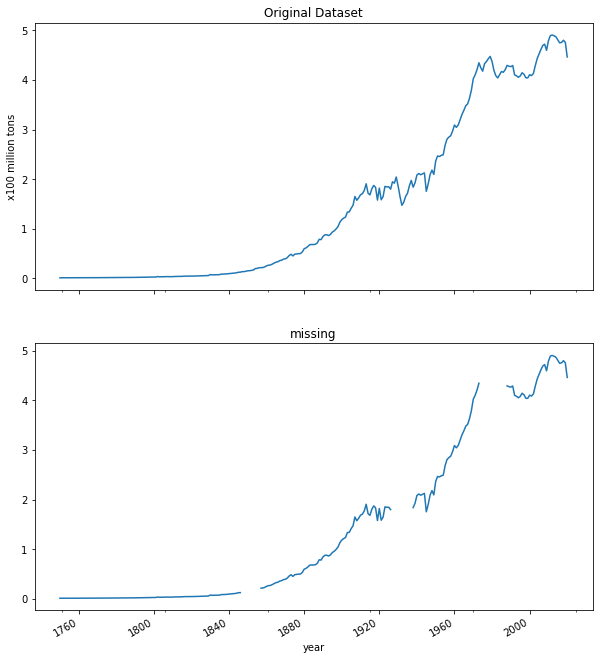

In [39]:
plot_dfs(co2_original, 
         co2_missing, 
         'co2',
         title="Annual CO2 Emission per Capita",
         xlabel="Years",
         ylabel="x100 million tons")

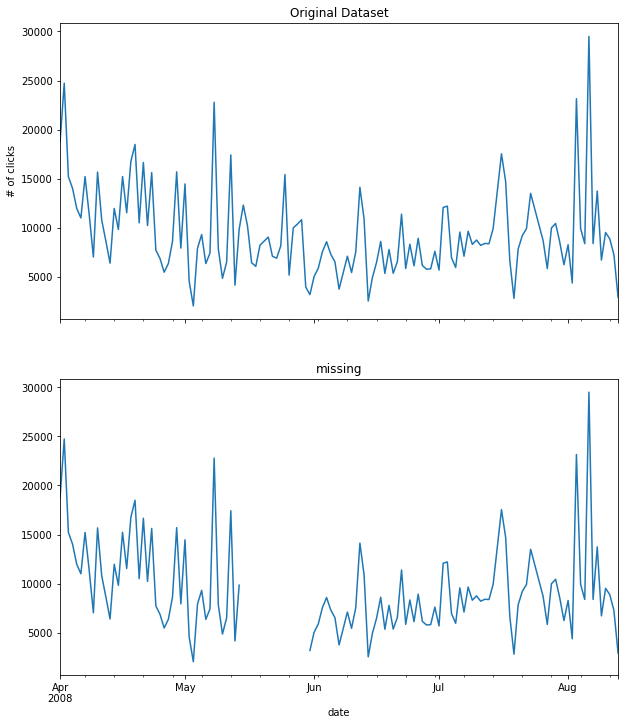

In [40]:
plot_dfs(clicks_original, 
         clicks_missing, 
         'clicks',
         title="Page Clicks per Day",
         xlabel="date",
         ylabel="# of clicks")

In [41]:
def rmse_score(df1, df2, col=None):
    '''
    df1: original dataframe without missing data
    df2: dataframe with missing data
    col: column name that contains missing data
    '''
    df_missing = df2.rename(columns={col: 'missing'})
    columns = df_missing.loc[:, 'missing':].columns.tolist()
    scores = []
    for comp_col in columns[1:]:
        rmse = np.sqrt(np.mean((df1[col] - df_missing[comp_col])**2))
        scores.append(rmse)
        print(f'RMSE for {comp_col}: {rmse}')
    return scores

In [42]:
co2_missing['ffil'] = co2_missing['co2'].fillna(method='FFILL')
co2_missing['bfill'] = co2_missing['co2'].fillna(method='BFILL')
co2_missing['mean'] = co2_missing['co2'].fillna(co2_missing['co2'].mean())

In [43]:
scores = rmse_score(co2_original, 
                    co2_missing, 
                    'co2')

RMSE for ffil: 0.05873012599267133
RMSE for bfill: 0.05550012995280968
RMSE for mean: 0.7156383637041684


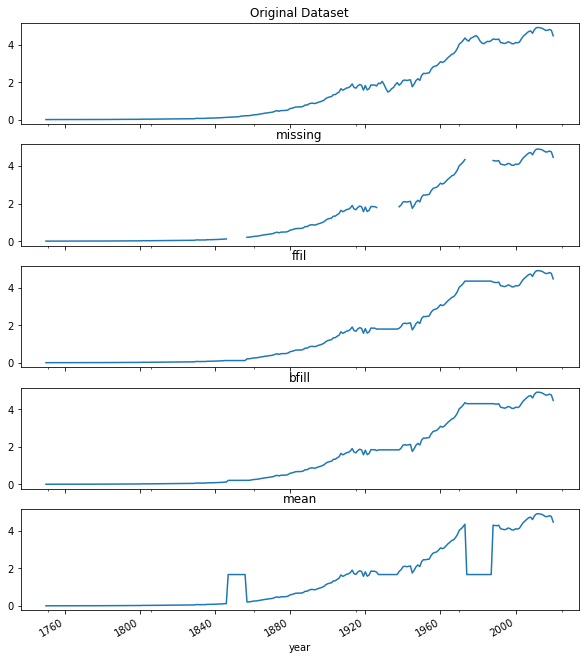

In [44]:
plot_dfs(co2_original, co2_missing, 'co2')

In [45]:
clicks_missing['ffil'] = clicks_missing['clicks'].fillna(method='ffill')
clicks_missing['bfill'] = clicks_missing['clicks'].fillna(method='bfill')
clicks_missing['mean'] = clicks_missing['clicks'].fillna(clicks_missing['clicks'].mean())

In [46]:
scores = rmse_score(clicks_original, 
                    clicks_missing, 
                    'clicks')

RMSE for ffil: 1034.1210689204554
RMSE for bfill: 2116.6840489225033
RMSE for mean: 997.7600138929953


In [47]:
def plot_dfs(df1, df2, col, title=None, xlabel=None, ylabel=None):
    '''
    df1: original dataframe without missing data
    df2: dataframe with missing data
    col: column name that contains missing data
    '''
    
    df_missing = df2.rename(columns={col: 'missing'})
    
    columns = df_missing.loc[:, 'missing':].columns.tolist()    
    print(columns)
    subplots_size = len(columns)-2
    
    fig, ax = plt.subplots(subplots_size+1, 1, sharex=True)
    
    fig.suptitle = title
    
    
    for i, colname in enumerate(columns[1:]):
        df_missing[colname].plot(ax=ax[i], figsize=(10, 8))
        ax[i].set_title(colname)
    plt.show()

['missing', 'ffil', 'bfill', 'mean']


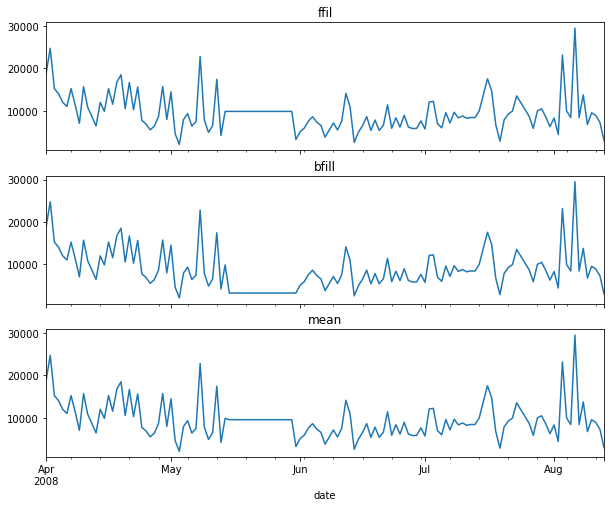

In [48]:
plot_dfs(clicks_original, clicks_missing, 'clicks')

**This is a better approach**
* Combine the two datasets into one and just a column called missing and column called original 
* though subplots will be introduced in Chapter 8


array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>],
      dtype=object)

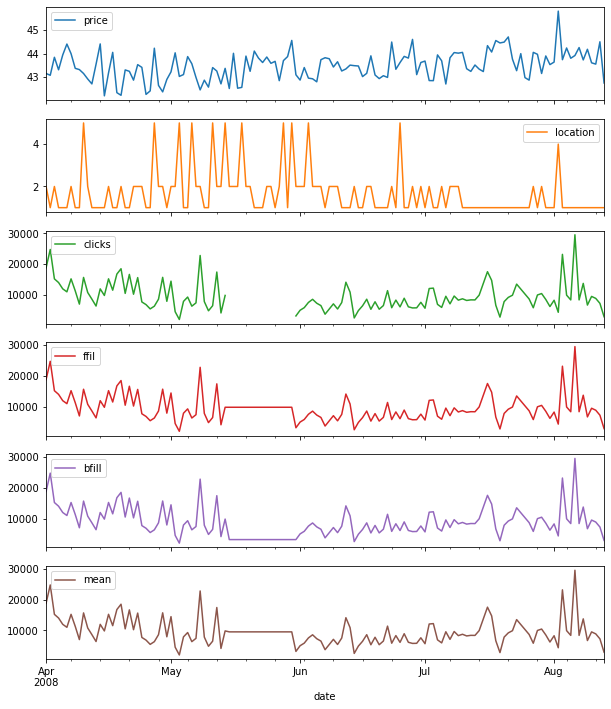

In [49]:
clicks_missing.plot(subplots=True, figsize=(10, 12))

### There is More

In [50]:
co2_missing['co2'].ffill()
co2_missing['co2'].bfill()
clicks_missing['clicks'].ffill()
clicks_missing['clicks'].bfill()

date
2008-04-01    18784.0
2008-04-02    24738.0
2008-04-03    15209.0
2008-04-04    14018.0
2008-04-05    11974.0
               ...   
2008-08-09     6716.0
2008-08-10     9523.0
2008-08-11     8881.0
2008-08-12     7272.0
2008-08-13     2922.0
Name: clicks, Length: 135, dtype: float64

# Handling Missing Data with Univariate Imputation using Scikit-Learn

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from pathlib import Path

In [52]:
def read_dataset(folder, file, date_col=None):
    df = pd.read_csv(folder / file, 
                     index_col=date_col, 
                     parse_dates=[date_col])
    return df

folder = Path('../../datasets/Ch7/')

co2_original = read_dataset(folder, 
                            'co2_original.csv', 'year')
co2_missing = read_dataset(folder, 
                           'co2_missing_only.csv', 'year')
clicks_original = read_dataset(folder, 
                               'clicks_original.csv', 'date')
clicks_missing = read_dataset(folder, 
                              'clicks_missing.csv', 'date')

In [53]:
def plot_dfs(df1, df2, col, title=None, xlabel=None, ylabel=None):
    '''
    df1: original dataframe without missing data
    df2: dataframe with missing data
    col: column name that contains missing data
    '''
    
    df_missing = df2.rename(columns={col: 'missing'})
    
    columns = df_missing.loc[:, 'missing':].columns.tolist()
    subplots_size = len(columns)
    
    # subplots_size = df2.shape[1]
    fig, ax = plt.subplots(subplots_size+1, 1, sharex=True)
    
    fig.suptitle = title
    #fig.tight_layout()
    
    df1[col].plot(ax=ax[0], figsize=(10, 12))
    ax[0].set_title('Original Dataset')
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel(ylabel)
    
    
    for i, colname in enumerate(columns):
        df_missing[colname].plot(ax=ax[i+1])
        ax[i+1].set_title(colname.upper())
    plt.show()

In [54]:
def rmse_score(df1, df2, col=None):
    '''
    df1: original dataframe without missing data
    df2: dataframe with missing data
    col: column name that contains missing data
    '''
    df_missing = df2.rename(columns={col: 'missing'})
    columns = df_missing.loc[:, 'missing':].columns.tolist()
    scores = []
    for comp_col in columns[1:]:
        rmse = np.sqrt(np.mean((df1[col] - df_missing[comp_col])**2))
        scores.append(rmse)
        print(f'RMSE for {comp_col}: {rmse}')
    return scores

In [55]:
strategy = [
    ('Mean Strategy', 'mean'),
    ('Median Strategy', 'median'),
    ('Most Frequent Strategy', 'most_frequent')]

In [56]:
for s_name, s in strategy:
    co2_vals = co2_missing['co2'].values.reshape(-1,1)
    clicks_vals = clicks_missing['clicks'].values.reshape(-1,1)
    co2_missing[s_name] = (SimpleImputer(strategy=s)
                               .fit_transform(co2_vals))
    clicks_missing[s_name] = (SimpleImputer(strategy=s)
                                .fit_transform(clicks_vals))
    
    

In [57]:
_ = rmse_score(co2_original, co2_missing, 'co2')

RMSE for Mean Strategy: 0.7156383637041684
RMSE for Median Strategy: 0.8029421606859859
RMSE for Most Frequent Strategy: 1.1245663822743381


In [58]:
_ = rmse_score(clicks_original, clicks_missing, 'clicks')

RMSE for Mean Strategy: 997.7600138929953
RMSE for Median Strategy: 959.3580492530756
RMSE for Most Frequent Strategy: 1097.6425985146868


In [59]:
def plot_dfs(df1, df2, col, title=None, xlabel=None, ylabel=None):
    '''
    df1: original dataframe without missing data
    df2: dataframe with missing data
    col: column name that contains missing data
    '''
    
    df_missing = df2.rename(columns={col: 'missing'})
    
    columns = df_missing.loc[:, 'missing':].columns.tolist()    
    print(columns)
    subplots_size = len(columns)-2
    
    fig, ax = plt.subplots(subplots_size+1, 1, sharex=True)
    
    fig.suptitle = title
    
    
    for i, colname in enumerate(columns[1:]):
        df_missing[colname].plot(ax=ax[i], figsize=(10, 8))
        ax[i].set_title(colname)
    plt.show()

['missing', 'Mean Strategy', 'Median Strategy', 'Most Frequent Strategy']


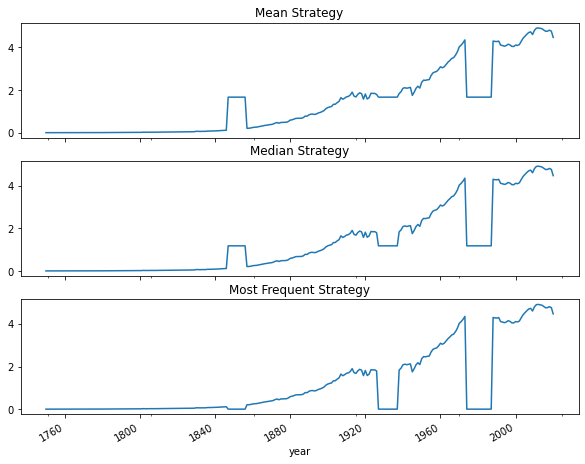

In [60]:
plot_dfs(co2_original, co2_missing, 'co2')

['missing', 'Mean Strategy', 'Median Strategy', 'Most Frequent Strategy']


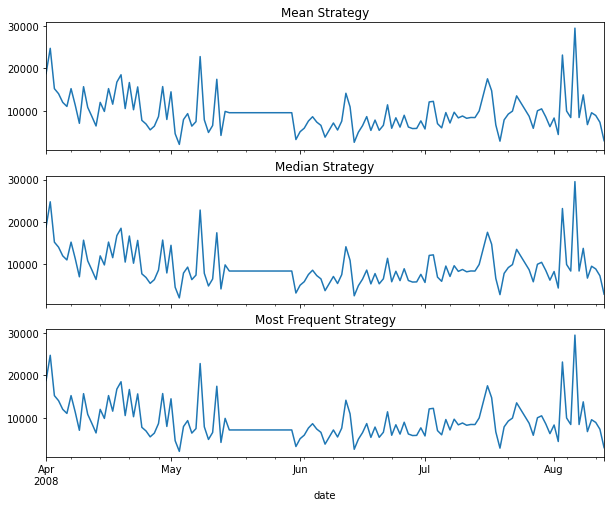

In [61]:
plot_dfs(clicks_original, clicks_missing, 'clicks')

## There is more

In [62]:
avg = co2_missing['co2'].mean()
co2_missing['pands_fillna'] = co2_missing['co2'].fillna(avg)

In [63]:
co2_missing

,co2,Mean Strategy,Median Strategy,Most Frequent Strategy,pands_fillna
year,,,,,
1750-01-01,0.0125,0.0125,0.0125,0.0125,0.0125
1760-01-01,0.0128,0.0128,0.0128,0.0128,0.0128
1770-01-01,0.0150,0.0150,0.0150,0.0150,0.0150
1780-01-01,0.0169,0.0169,0.0169,0.0169,0.0169
1790-01-01,0.0206,0.0206,0.0206,0.0206,0.0206
...,...,...,...,...,...
2016-01-01,4.7496,4.7496,4.7496,4.7496,4.7496
2017-01-01,4.7595,4.7595,4.7595,4.7595,4.7595
2018-01-01,4.8022,4.8022,4.8022,4.8022,4.8022


In [64]:
cols = ['co2', 'Mean Strategy', 'pands_fillna']
_ = rmse_score(co2_original, co2_missing[cols], 'co2')

RMSE for Mean Strategy: 0.7156383637041684
RMSE for pands_fillna: 0.7156383637041684


# Handling Missing Data with Multivariate Imputation

In [65]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor, BaggingRegressor
from sklearn.linear_model import ElasticNet, LinearRegression, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor

In [66]:
def read_dataset(folder, file, date_col=None):
    df = pd.read_csv(folder / file, 
                     index_col=date_col, 
                     parse_dates=[date_col])
    return df

In [67]:
def plot_dfs(df1, df2, col, title=None, xlabel=None, ylabel=None):
    '''
    df1: original dataframe without missing data
    df2: dataframe with missing data
    col: column name that contains missing data
    '''
    
    df_missing = df2.rename(columns={col: 'missing'})
    
    columns = df_missing.loc[:, 'missing':].columns.tolist()
    subplots_size = len(columns)
    
    # subplots_size = df2.shape[1]
    fig, ax = plt.subplots(subplots_size+1, 1, sharex=True)
    
    fig.suptitle = title
    fig.tight_layout()
    
    df1[col].plot(ax=ax[0], figsize=(10, 12))
    ax[0].set_title('Original Dataset')
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel(ylabel)
    
    
    for i, colname in enumerate(columns):
        df_missing[colname].plot(ax=ax[i+1])
        ax[i+1].set_title(colname.upper())
    plt.show()

In [68]:
def rmse_score(df1, df2, col=None):
    '''
    df1: original dataframe without missing data
    df2: dataframe with missing data
    col: column name that contains missing data
    '''
    df_missing = df2.rename(columns={col: 'missing'})
    columns = df_missing.loc[:, 'missing':].columns.tolist()
    scores = []
    for comp_col in columns[1:]:
        rmse = np.sqrt(np.mean((df1[col] - df_missing[comp_col])**2))
        scores.append(rmse)
        print(f'RMSE for {comp_col}: {rmse}')
    return scores

In [69]:
folder = Path('../../datasets/Ch7/')

clicks_original = read_dataset(folder, 
                            'clicks_original.csv', 'date')
clicks_missing = read_dataset(folder, 
                            'clicks_missing.csv', 'date')

In [70]:
clicks_missing.isna().sum()

price        0
location     0
clicks      16
dtype: int64

In [71]:
estimators = [
    ('bayesianRidge', BayesianRidge()),
    ('extra_trees', ExtraTreesRegressor(n_estimators=10)),
    ('bagging', BaggingRegressor(n_estimators=10)),
    ('elastic_net', ElasticNet()),
    ('linear_regression', LinearRegression()),
    ('knn', KNeighborsRegressor(n_neighbors=3))
]


In [72]:
clicks_vals = clicks_missing.iloc[:,0:3].values

for e_name, e in estimators:
    est = IterativeImputer(
                random_state=15,
                estimator=e).fit(clicks_vals)
    clicks_missing[e_name] = est.transform(clicks_vals)[: , 2]

    
    

/Users/tarekatwan/opt/anaconda3/envs/ch2/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/tarekatwan/opt/anaconda3/envs/ch2/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [73]:
_ = rmse_score(clicks_original, clicks_missing, 'clicks')

RMSE for bayesianRidge: 949.439397345585
RMSE for extra_trees: 1667.9039086141536
RMSE for bagging: 1191.7666362107916
RMSE for elastic_net: 945.4075209343101
RMSE for linear_regression: 938.9419831427186
RMSE for knn: 1336.8798392251822


In [74]:
def plot_dfs(df1, df2, col, title=None, xlabel=None, ylabel=None):
    '''
    df1: original dataframe without missing data
    df2: dataframe with missing data
    col: column name that contains missing data
    '''
    
    df_missing = df2.rename(columns={col: 'missing'})
    
    columns = df_missing.loc[:, 'missing':].columns.tolist()    
    print(columns)
    subplots_size = len(columns)-2
    
    fig, ax = plt.subplots(subplots_size+1, 1, sharex=True)
    
    fig.suptitle = title
    fig.tight_layout()
    
    
    for i, colname in enumerate(columns[1:]):
        df_missing[colname].plot(ax=ax[i], figsize=(10, 8))
        ax[i].set_title(colname)
    plt.show()

['missing', 'bayesianRidge', 'extra_trees', 'bagging', 'elastic_net', 'linear_regression', 'knn']


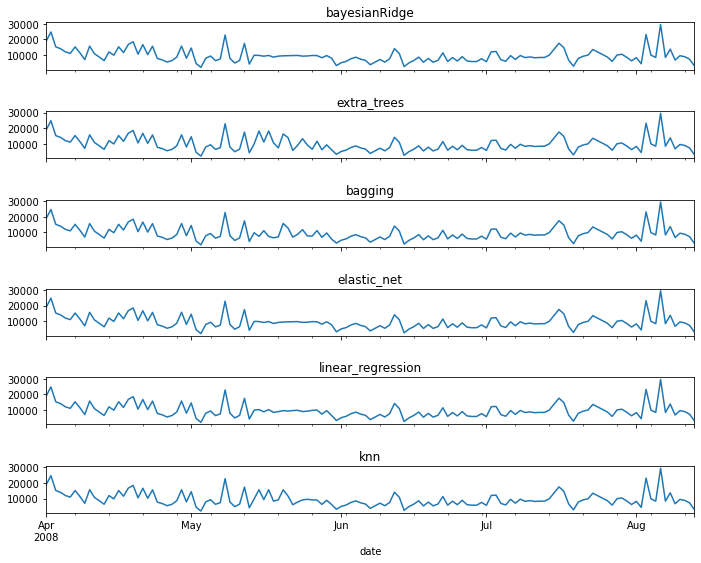

In [75]:

plot_dfs(clicks_original, clicks_missing, 'clicks')

### There is more

In [76]:
from statsmodels.imputation.mice import MICE, MICEData, MICEResults
import statsmodels.api as sm

In [77]:
# create a MICEData object
fltr = ['price', 'location','clicks']
mice_data = MICEData(clicks_missing[fltr], 
                     perturbation_method='gaussian')
# 20 iterations
mice_data.update_all(n_iter=20)

mice_data.set_imputer('clicks', formula='~ price + location', model_class=sm.OLS)

In [78]:
clicks_missing['MICE']  = mice_data.data['clicks'].values.tolist()

In [79]:
_ = rmse_score(clicks_original, clicks_missing, 'clicks')

RMSE for bayesianRidge: 949.439397345585
RMSE for extra_trees: 1667.9039086141536
RMSE for bagging: 1191.7666362107916
RMSE for elastic_net: 945.4075209343101
RMSE for linear_regression: 938.9419831427186
RMSE for knn: 1336.8798392251822
RMSE for MICE: 1237.251778322813


['missing', 'bayesianRidge', 'bagging', 'knn', 'MICE']


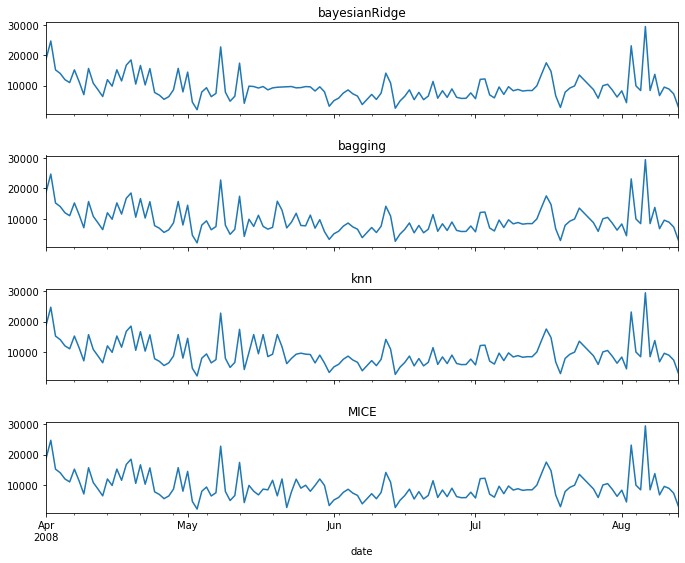

In [80]:
cols = ['clicks','bayesianRidge', 'bagging', 'knn', 'MICE']
plot_dfs(clicks_original, clicks_missing[cols], 'clicks')

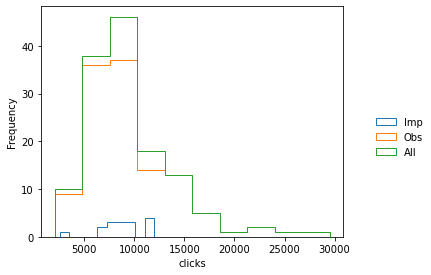

In [81]:
_ = mice_data.plot_imputed_hist('clicks')

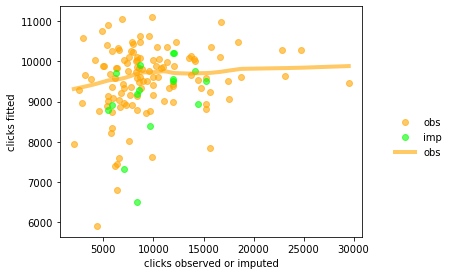

In [82]:
mice_data = MICEData(clicks_missing[fltr], 
                     perturbation_method='gaussian')
mice_data.update_all(n_iter=20)
_ = mice_data.plot_fit_obs('clicks')

# Handling Missing Data with Interpolation

In [83]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

In [84]:
def read_dataset(folder, file, date_col=None):
    df = pd.read_csv(folder / file, 
                     index_col=date_col, 
                     parse_dates=[date_col])
    return df

In [85]:
def plot_dfs(df1, df2, col, title=None, xlabel=None, ylabel=None):
    '''
    df1: original dataframe without missing data
    df2: dataframe with missing data
    col: column name that contains missing data
    '''
    
    df_missing = df2.rename(columns={col: 'missing'})
    
    columns = df_missing.loc[:, 'missing':].columns.tolist()
    subplots_size = len(columns)
    
    # subplots_size = df2.shape[1]
    fig, ax = plt.subplots(subplots_size+1, 1, sharex=True)
#     fig.tight_layout()
    fig.suptitle = title
    
    
    df1[col].plot(ax=ax[0], figsize=(10, 12))
    ax[0].set_title('Original Dataset')
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel(ylabel)
    
    
    for i, colname in enumerate(columns):
        df_missing[colname].plot(ax=ax[i+1])
        ax[i+1].set_title(colname.upper())
    plt.show()

In [86]:
def rmse_score(df1, df2, col=None):
    '''
    df1: original dataframe without missing data
    df2: dataframe with missing data
    col: column name that contains missing data
    '''
    df_missing = df2.rename(columns={col: 'missing'})
    columns = df_missing.loc[:, 'missing':].columns.tolist()
    scores = []
    for comp_col in columns[1:]:
        rmse = np.sqrt(np.mean((df1[col] - df_missing[comp_col])**2))
        scores.append(rmse)
        print(f'RMSE for {comp_col}: {rmse}')
    return scores

In [87]:
folder = Path('../../datasets/Ch7/')

co2_original = read_dataset(folder, 
                            'co2_original.csv', 'year')
co2_missing = read_dataset(folder, 
                           'co2_missing_only.csv', 'year')
clicks_original = read_dataset(folder, 
                               'clicks_original.csv', 'date')
clicks_missing = read_dataset(folder, 
                              'clicks_missing.csv', 'date')

In [88]:
interpolations = [
    'linear',
    'quadratic',
    'nearest',
    'cubic'
]

for intp in interpolations:
    co2_missing[intp] = co2_missing['co2'].interpolate(method=intp)
    clicks_missing[intp] = clicks_missing['clicks'].interpolate(method=intp)


co2_missing['spline'] = \
        co2_missing['co2'].interpolate(method='spline', order=2)
clicks_missing['spline'] = \
        clicks_missing['clicks'].interpolate(method='spline',order=2)

co2_missing['polynomial'] = \
        co2_missing['co2'].interpolate(method='polynomial',order=5)
clicks_missing['polynomial'] = \
        clicks_missing['clicks'].interpolate(method='polynomial',order=5)



In [89]:
_ = rmse_score(co2_original, co2_missing, 'co2')

RMSE for linear: 0.05507291327761665
RMSE for quadratic: 0.08367561505614347
RMSE for nearest: 0.05385422309469095
RMSE for cubic: 0.08373627305833133
RMSE for spline: 0.1878602347541416
RMSE for polynomial: 0.06728323553134927


In [90]:
_ = rmse_score(clicks_original, clicks_missing, 'clicks')

RMSE for linear: 1329.1448378562811
RMSE for quadratic: 5224.641260626975
RMSE for nearest: 1706.1853705030173
RMSE for cubic: 6199.304875782831
RMSE for spline: 5222.922993448641
RMSE for polynomial: 56757.29323647127


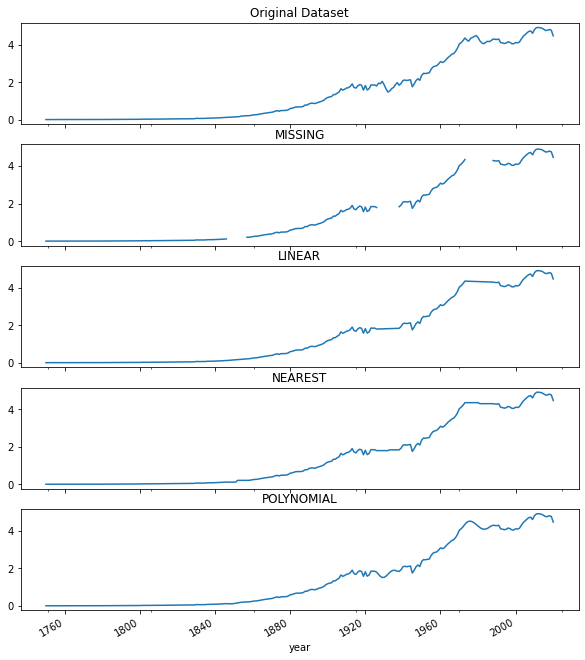

In [91]:
cols = ['co2', 'linear', 'nearest', 'polynomial']
plot_dfs(co2_original, co2_missing[cols], 'co2')

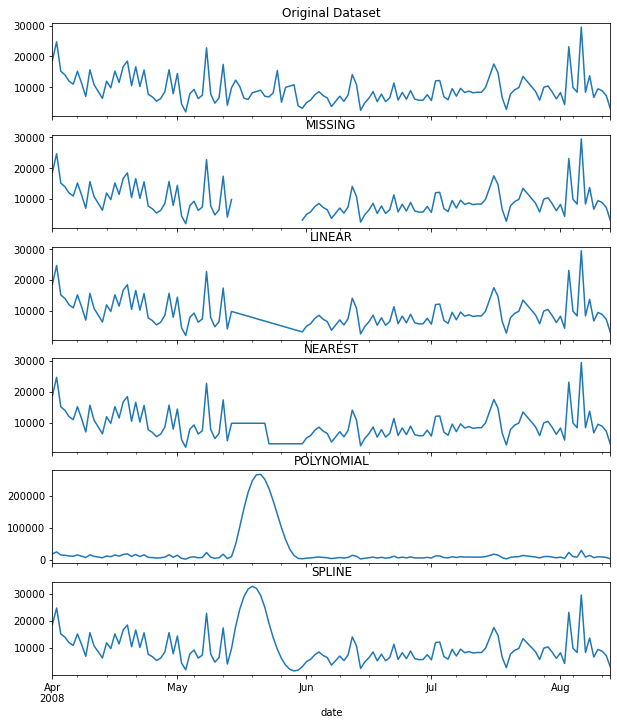

In [92]:
cols = ['clicks', 'linear', 'nearest', 'polynomial', 'spline']
plot_dfs(clicks_original, clicks_missing[cols], 'clicks')

### How it works

In [93]:
clicks_missing['clicks'].isna().sum()

16

In [94]:
example = clicks_missing['clicks'].interpolate(limit = 5)

In [95]:
example.isna().sum()

11

In [96]:
clicks_missing['clicks']['2008-05-14':]

date
2008-05-14    9841.0
2008-05-15       NaN
2008-05-16       NaN
2008-05-17       NaN
2008-05-18       NaN
               ...  
2008-08-09    6716.0
2008-08-10    9523.0
2008-08-11    8881.0
2008-08-12    7272.0
2008-08-13    2922.0
Name: clicks, Length: 92, dtype: float64

In [97]:
example['2008-05-14':]

date
2008-05-14    9841.0
2008-05-15    9450.0
2008-05-16    9059.0
2008-05-17    8668.0
2008-05-18    8277.0
               ...  
2008-08-09    6716.0
2008-08-10    9523.0
2008-08-11    8881.0
2008-08-12    7272.0
2008-08-13    2922.0
Name: clicks, Length: 92, dtype: float64

### There is more

In [98]:
clicks_original = read_dataset(folder, 
                               'clicks_original.csv', 'date')
clicks_missing = read_dataset(folder, 
                              'clicks_missing.csv', 'date')

In [99]:
clicks_missing.head()

,price,location,clicks
date,,,
2008-04-01,43.155647,2,18784.0
2008-04-02,43.079056,1,24738.0
2008-04-03,43.842609,2,15209.0
2008-04-04,43.312376,1,14018.0
2008-04-05,43.941176,1,11974.0


In [100]:
clicks_missing['clicks']['2008-05-14':]

date
2008-05-14    9841.0
2008-05-15       NaN
2008-05-16       NaN
2008-05-17       NaN
2008-05-18       NaN
               ...  
2008-08-09    6716.0
2008-08-10    9523.0
2008-08-11    8881.0
2008-08-12    7272.0
2008-08-13    2922.0
Name: clicks, Length: 92, dtype: float64

In [101]:
clicks_missing.shape

(135, 3)

# Resampling Time Series Data

In [102]:
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt


In [103]:
df = web.DataReader('TSLA', 'yahoo', start='2020-01-01', end='2021-11-01')

In [104]:
df.loc[: , 'Close':].head()

,Close,Volume,Adj Close
Date,,,
2020-01-02,86.052002,47660500.0,86.052002
2020-01-03,88.601997,88892500.0,88.601997
2020-01-06,90.307999,50665000.0,90.307999
2020-01-07,93.811996,89410500.0,93.811996
2020-01-08,98.428001,155721500.0,98.428001


In [105]:
df.shape

(463, 6)

In [106]:
df_downsampled = df.resample('3D').last()
df_downsampled.loc[: , 'Close':].head()

,Close,Volume,Adj Close
Date,,,
2020-01-02,88.601997,88892500.0,88.601997
2020-01-05,93.811996,89410500.0,93.811996
2020-01-08,95.629997,64797500.0,95.629997
2020-01-11,104.972000,132588000.0,104.972000
2020-01-14,102.697998,108683500.0,102.697998


In [107]:
df_downsampled.index

DatetimeIndex(['2020-01-02', '2020-01-05', '2020-01-08', '2020-01-11',
               '2020-01-14', '2020-01-17', '2020-01-20', '2020-01-23',
               '2020-01-26', '2020-01-29',
               ...
               '2021-10-05', '2021-10-08', '2021-10-11', '2021-10-14',
               '2021-10-17', '2021-10-20', '2021-10-23', '2021-10-26',
               '2021-10-29', '2021-11-01'],
              dtype='datetime64[ns]', name='Date', length=224, freq='3D')

In [108]:
df_downsampled.index.freq

<3 * Days>

In [109]:
df_downsampled = df.resample('3B').last()
df_downsampled.loc[: , 'Close':].head()

,Close,Volume,Adj Close
Date,,,
2020-01-02,90.307999,50665000.0,90.307999
2020-01-07,96.267998,142202000.0,96.267998
2020-01-10,107.584000,144981000.0,107.584000
2020-01-15,102.099998,68145500.0,102.099998
2020-01-20,113.912003,156845000.0,113.912003


In [110]:
df_weekly = df.resample('W').mean()
df_monthly = df.resample('M').mean()
# df_quarterly = df.resample('Q').mean()

In [111]:
weekly_return = df_weekly['Close'].pct_change()
monthly_return = df_monthly['Close'].pct_change()
# quarterly_return = df_quarterly['Close'].pct_change()

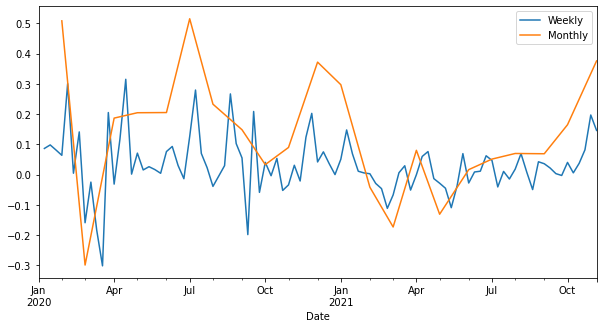

In [112]:
plt.figure(figsize=(10,5))
weekly_return.plot(label='Weekly')
monthly_return.plot(label='Monthly')
plt.legend()
plt.show()

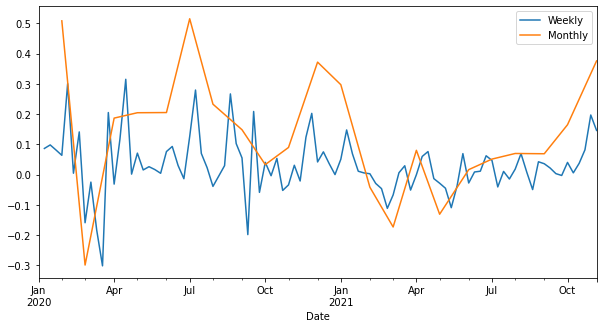

In [113]:
# similary this can be reduced into shorter steps
plt.figure(figsize=(10,5))
df.resample('W').mean()['Close'].pct_change().plot(label='Weekly')
df.resample('M').mean()['Close'].pct_change().plot(label='Monthly')
plt.legend()
plt.show()

### There is more

In [114]:
df.resample('M').mean()
df.resample('M').std()
df.resample('M').median()
df.resample('M').last().head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-01-31,130.600006,126.503998,128.000000,130.113998,78596500.0,130.113998
2020-02-29,138.104004,122.304001,125.940002,133.598007,121114500.0,133.598007
2020-03-31,108.592003,99.400002,100.250000,104.800003,88857500.0,104.800003
2020-04-30,173.964005,152.699997,171.037994,156.376007,142359500.0,156.376007
2020-05-31,167.000000,160.841995,161.750000,167.000000,58822500.0,167.000000


In [115]:
df.resample('H').ffill().head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-01-02 00:00:00,86.139999,84.342003,84.900002,86.052002,47660500.0,86.052002
2020-01-02 01:00:00,86.139999,84.342003,84.900002,86.052002,47660500.0,86.052002
2020-01-02 02:00:00,86.139999,84.342003,84.900002,86.052002,47660500.0,86.052002
2020-01-02 03:00:00,86.139999,84.342003,84.900002,86.052002,47660500.0,86.052002
2020-01-02 04:00:00,86.139999,84.342003,84.900002,86.052002,47660500.0,86.052002


# Dealing with Outliers in Time Series Data

In [289]:
import pandas as pd
import matplotlib.pyplot as plt

from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.lof import LOF
from pyod.models.knn import KNN
from pyod.models.copod import COPOD

from pyod.utils.utility import standardizer

from pathlib import Path

In [302]:
# df = pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/realTraffic/speed_6005.csv',
#                 index_col='timestamp',
#                 parse_dates=True)
# file = Path('../../datasets/Ch7/speed_7578.csv')
# df.to_csv(file)

In [310]:
file = Path('../../datasets/Ch7/speed_7578.csv')
df = pd.read_csv(file,
                index_col='timestamp',
                parse_dates=True)

scaled = standardizer(df)
df_scaled = pd.DataFrame(data=scaled, index=df.index, columns=['value'])
df_scaled.head()

,value
timestamp,
2015-08-31 18:22:00,0.925481
2015-08-31 18:32:00,-0.218048
2015-08-31 18:57:00,0.239364
2015-08-31 19:07:00,1.382893
2015-08-31 19:12:00,0.925481


In [311]:
df_scaled.describe()

,value
count,2.500000e+03
mean,-5.026202e-16
std,1.000200e+00
min,-7.079224e+00
25%,-5.611070e-01
50%,1.065769e-02
75%,6.967753e-01
max,3.098187e+00


<AxesSubplot:xlabel='timestamp'>

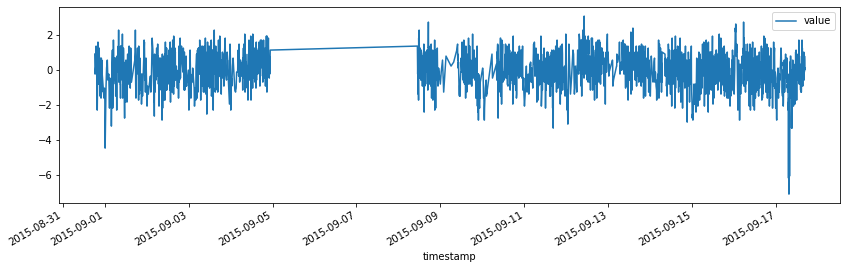

In [307]:
df_scaled.plot(figsize=(14, 4))

In [330]:
random_state = np.random.RandomState(42)
outliers_fraction = 0.02

classifiers = {
        'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
        'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
        'Average KNN': KNN(method='mean',contamination=outliers_fraction),
        'Local Outlier Factor': LOF(n_neighbors=20, contamination=outliers_fraction),
        'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=outliers_fraction),
        'Copula-Based Outlier Detection (COPOD)' : COPOD(contamination=outliers_fraction)
}

In [331]:
# X = df_scaled.values.reshape(-1,1)

In [332]:
for clf_name, clf in classifiers.items():
    clf.fit(scaled)
    y_pred = clf.predict(scaled)
    
    df_scaled[clf_name] = y_pred

In [343]:
df_scaled.columns

Index(['value', 'Isolation Forest', 'K Nearest Neighbors (KNN)', 'Average KNN',
       'Local Outlier Factor', 'Histogram-base Outlier Detection (HBOS)',
       'Copula-Based Outlier Detection (COPOD)'],
      dtype='object')

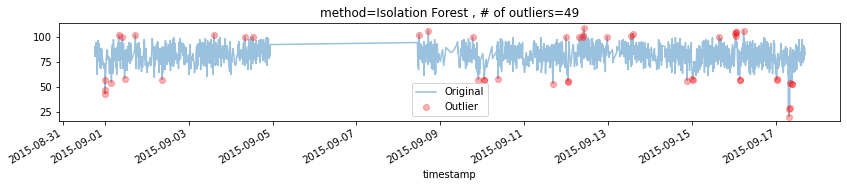

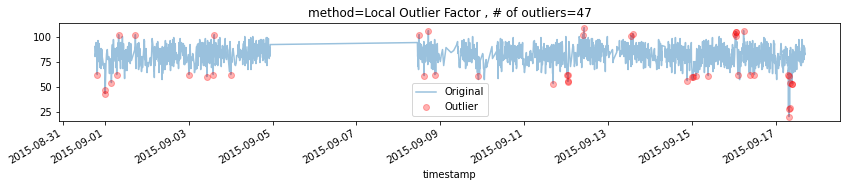

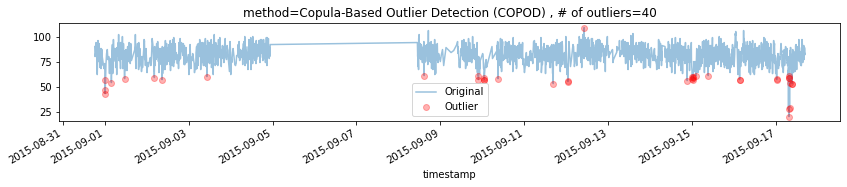

In [344]:
for c in df_scaled[['Isolation Forest', 'Local Outlier Factor', 'Copula-Based Outlier Detection (COPOD)']]:
    cnt = df_scaled[c].sum()
    ax = df.plot(figsize=(14, 2), 
                 title=f'method={c} , # of outliers={cnt}', 
                 alpha=0.45)
    vals = df_scaled[df_scaled[c] == 1].index
    df.loc[vals].plot(style='o',
                      color='red', 
                      ax=ax,
                      alpha=0.30)
    plt.legend(['Original', 'Outlier'])
    plt.show()

In [345]:
df.shape

(2500, 1)

### There is more

In [483]:
from kats.detectors.outlier import OutlierDetector
from kats.consts import TimeSeriesData

In [484]:
file = Path('../../datasets/Ch7/TravelTime_387.csv')

In [492]:
df = pd.read_csv(file, 
                 header=0, 
                 names=['time', 'value'], 
                 parse_dates=['time'])

In [493]:
ts = TimeSeriesData(df)

In [500]:
ts_outliers = OutlierDetector(ts, iqr_mult=0.5)

In [501]:
ts_outliers.detector()

In [502]:
ts_outliers.outliers[0]

[Timestamp('2015-07-13 14:24:00'),
 Timestamp('2015-07-14 14:24:00'),
 Timestamp('2015-07-15 14:24:00'),
 Timestamp('2015-07-16 14:24:00'),
 Timestamp('2015-08-23 14:24:00'),
 Timestamp('2015-08-24 14:24:00'),
 Timestamp('2015-08-25 14:24:00'),
 Timestamp('2015-08-26 14:24:00'),
 Timestamp('2015-08-27 14:24:00'),
 Timestamp('2015-08-28 14:24:00'),
 Timestamp('2015-08-31 14:24:00'),
 Timestamp('2015-09-01 14:24:00')]